In [90]:
from googleapiclient.discovery import build
import pandas as pd
from dateutil import parser
import isodate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

from IPython.display import JSON

In [12]:
api_key = 'XXX'

In [57]:
channel_ids = ['UCJQJAI7IjbLcpsjWdSzYz0Q', #Alex The Analyst
               'UC7cs8q-gJRlGwj4A8OmCmXg', #Technical Guruji	
               'UCV0qA-eDDICsRR9rPcnG7tw', #Marques Brownlee	
               'UCOhHO2ICt0ti9KAh-QHvttQ', #Mrwhosetheboss
               'UCMiJRAwDNSNzuYeN2uWa0pA', #Joma Tech	
               'UCBJycsmduvYEL83R_U4JriQ'  #Thu Vu data analytics	
               
             ]
youtube = build('youtube', 'v3', developerKey=api_key)

In [58]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [35]:
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids


In [59]:
channel_data = get_channel_stats(youtube, channel_ids)

In [60]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Alex The Analyst,662000,28292229,274,UU7cs8q-gJRlGwj4A8OmCmXg
1,Technical Guruji,23400000,3550924011,5278,UUOhHO2ICt0ti9KAh-QHvttQ
2,Marques Brownlee,18100000,3955935895,1617,UUBJycsmduvYEL83R_U4JriQ
3,Mrwhosetheboss,17600000,4843895223,1647,UUMiJRAwDNSNzuYeN2uWa0pA
4,Joma Tech,2270000,179409146,98,UUV0qA-eDDICsRR9rPcnG7tw
5,Thu Vu data analytics,186000,6195981,80,UUJQJAI7IjbLcpsjWdSzYz0Q


In [61]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [62]:
def get_video_details(youtube, video_ids):
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [63]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df._append(video_data, ignore_index=True)

Getting video information from channel: Alex The Analyst
Getting video information from channel: Technical Guruji
Getting video information from channel: Marques Brownlee
Getting video information from channel: Mrwhosetheboss
Getting video information from channel: Joma Tech
Getting video information from channel: Thu Vu data analytics


In [64]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,GZS7AgQ4Ksg,Alex The Analyst,Hard Skills vs Soft Skills,Hard Skills vs Soft Skills\n\n________________...,"[Data Analyst, Data Analyst job, Data Analyst ...",2024-01-08T13:06:02Z,1222,124,None,3,PT30S,hd,false
1,fT-8mRf_-Hk,Alex The Analyst,Solving Medium SQL Interview Questions on Anal...,Questions Page on Analyst Builder: https://www...,"[Data Analyst Career, Data Analytics, Alex The...",2024-01-04T13:00:28Z,10655,246,None,34,PT12M24S,hd,false
2,ZHaYOC0H5KE,Alex The Analyst,Solving Easy SQL Interview Questions on Analys...,Questions Page on Analyst Builder: https://www...,"[Data Analyst Career, Data Analytics, Alex The...",2024-01-02T13:00:25Z,18319,504,None,33,PT12M18S,hd,false
3,K0-8G3DgjA4,Alex The Analyst,How I Would Become a Data Analyst if I had to ...,If I had to start over here are the exact step...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-26T13:00:10Z,101731,4302,None,159,PT11M1S,hd,false
4,ZnAydTqCtFU,Alex The Analyst,Limit + Aliasing in MySQL | MySQL Beginner Series,Full MySQL Course: https://www.analystbuilder....,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-19T13:00:24Z,6446,161,None,7,PT3M57S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,5LWoJAh-kww,Thu Vu data analytics,Data Analyst Skill Stack // How I Became A Dat...,👩🏻‍💻 My laptop and iPad for doing DS/ study 👉 ...,None,2021-06-16T10:16:47Z,32518,1787,None,72,PT10M35S,hd,false
8985,_RzoHVWKwq4,Thu Vu data analytics,Effective visual note-taking on iPad + Downloa...,Hi there! In this video I’m showing you how to...,"[Note-taking, Study, iPad Pro, Visual note-tak...",2021-06-09T06:58:21Z,10294,364,None,12,PT8M19S,hd,false
8986,hWKLO7GtpiU,Thu Vu data analytics,Data scientist is NOT the only SEXY job // All...,Hi there! In this video I explain different da...,None,2021-06-01T22:51:42Z,8625,291,None,20,PT14M4S,hd,false
8987,dBZqggW22rs,Thu Vu data analytics,"How I take notes on iPad Pro | Notion, Notes, ...",My note-taking system tour in Notion and tips ...,"[Notes, Study, Productivity, Notion, Procreate...",2021-05-16T22:47:12Z,10612,259,None,19,PT9M7S,hd,false


In [65]:
# Writing video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')

# Data Pre-processing

In [66]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [67]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2008-03-29T01:03:44Z    1
2020-10-04T09:57:22Z    1
2020-10-02T09:33:44Z    1
2020-10-02T14:41:57Z    1
2020-10-02T21:53:13Z    1
                       ..
2017-10-04T18:49:24Z    1
2017-10-04T11:26:38Z    1
2017-10-04T07:48:19Z    1
2017-10-03T16:55:27Z    1
2024-01-08T13:06:02Z    1
Name: count, Length: 8989, dtype: int64

In [69]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [78]:
#Converting to string because it is in timestamp
video_df['publishedAt'] = video_df['publishedAt'].astype(str)
# Creating publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [79]:
# converting duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [80]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [81]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [82]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [83]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,GZS7AgQ4Ksg,Alex The Analyst,Hard Skills vs Soft Skills,Hard Skills vs Soft Skills\n\n________________...,"[Data Analyst, Data Analyst job, Data Analyst ...",2024-01-08 13:06:02+00:00,1222.0,124.0,NaN,3.0,PT30S,hd,false,Monday,0 days 00:00:30,5,101.472995,2.454992,26
1,fT-8mRf_-Hk,Alex The Analyst,Solving Medium SQL Interview Questions on Anal...,Questions Page on Analyst Builder: https://www...,"[Data Analyst Career, Data Analytics, Alex The...",2024-01-04 13:00:28+00:00,10655.0,246.0,NaN,34.0,PT12M24S,hd,false,Thursday,0 days 00:12:24,17,23.087752,3.190990,57
2,ZHaYOC0H5KE,Alex The Analyst,Solving Easy SQL Interview Questions on Analys...,Questions Page on Analyst Builder: https://www...,"[Data Analyst Career, Data Analytics, Alex The...",2024-01-02 13:00:25+00:00,18319.0,504.0,NaN,33.0,PT12M18S,hd,false,Tuesday,0 days 00:12:18,17,27.512419,1.801408,55
3,K0-8G3DgjA4,Alex The Analyst,How I Would Become a Data Analyst if I had to ...,If I had to start over here are the exact step...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-26 13:00:10+00:00,101731.0,4302.0,NaN,159.0,PT11M1S,hd,false,Tuesday,0 days 00:11:01,8,42.287995,1.562945,79
4,ZnAydTqCtFU,Alex The Analyst,Limit + Aliasing in MySQL | MySQL Beginner Series,Full MySQL Course: https://www.analystbuilder....,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-19 13:00:24+00:00,6446.0,161.0,NaN,7.0,PT3M57S,hd,false,Tuesday,0 days 00:03:57,5,24.976730,1.085945,49


## Exploratory Analysis

C:\Users\mihir\AppData\Local\Temp\ipykernel_20988\1912406227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(video_df,x=video_df['channelTitle'],y= video_df['viewCount'], palette = 'pastel')


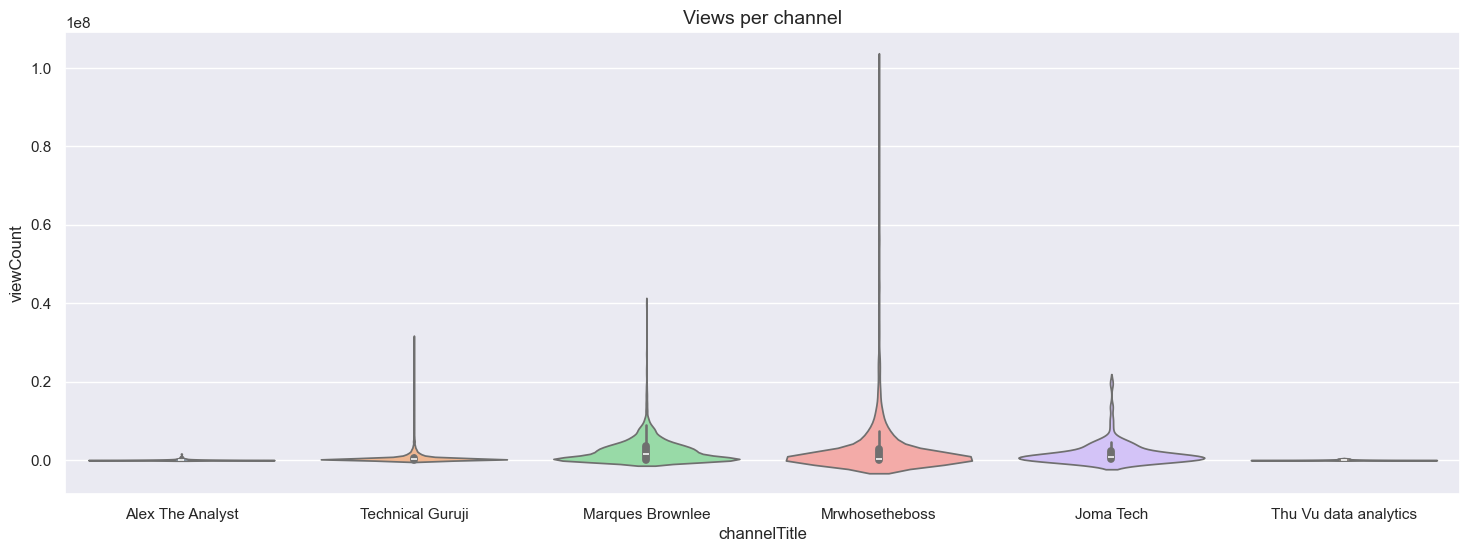

In [93]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(video_df,x=video_df['channelTitle'],y= video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

<Axes: xlabel='likeCount', ylabel='viewCount'>

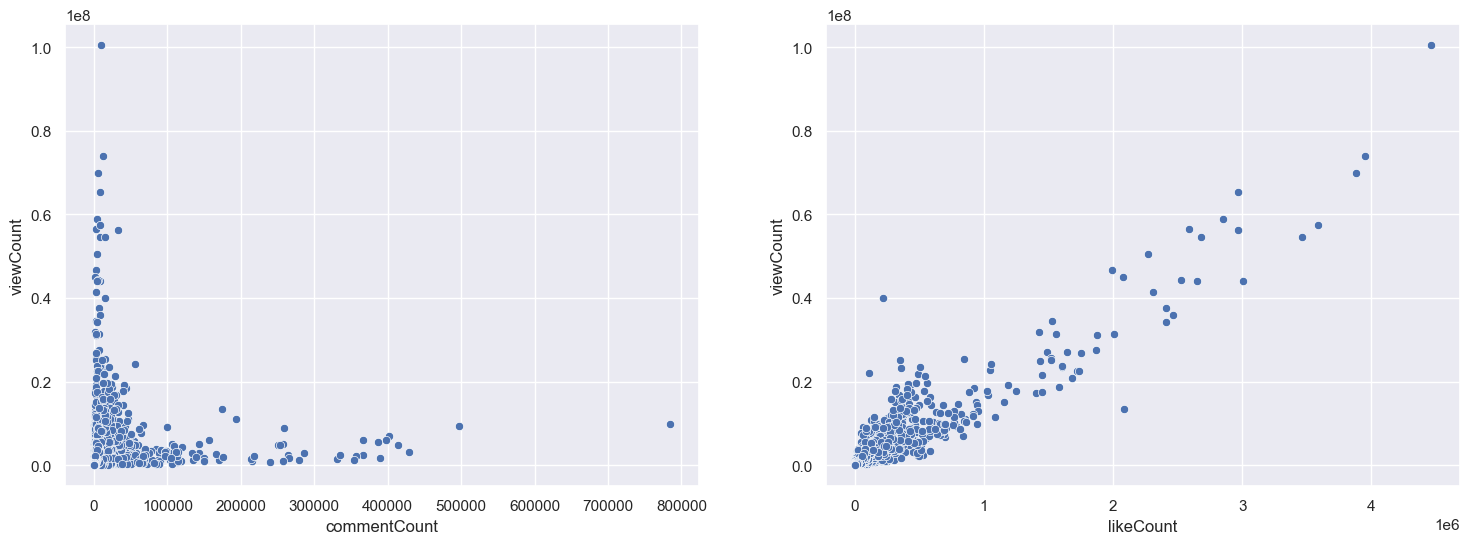

In [94]:
#Does the number of likes and comments matter for a video to get more views?
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<Axes: xlabel='likeRatio', ylabel='viewCount'>

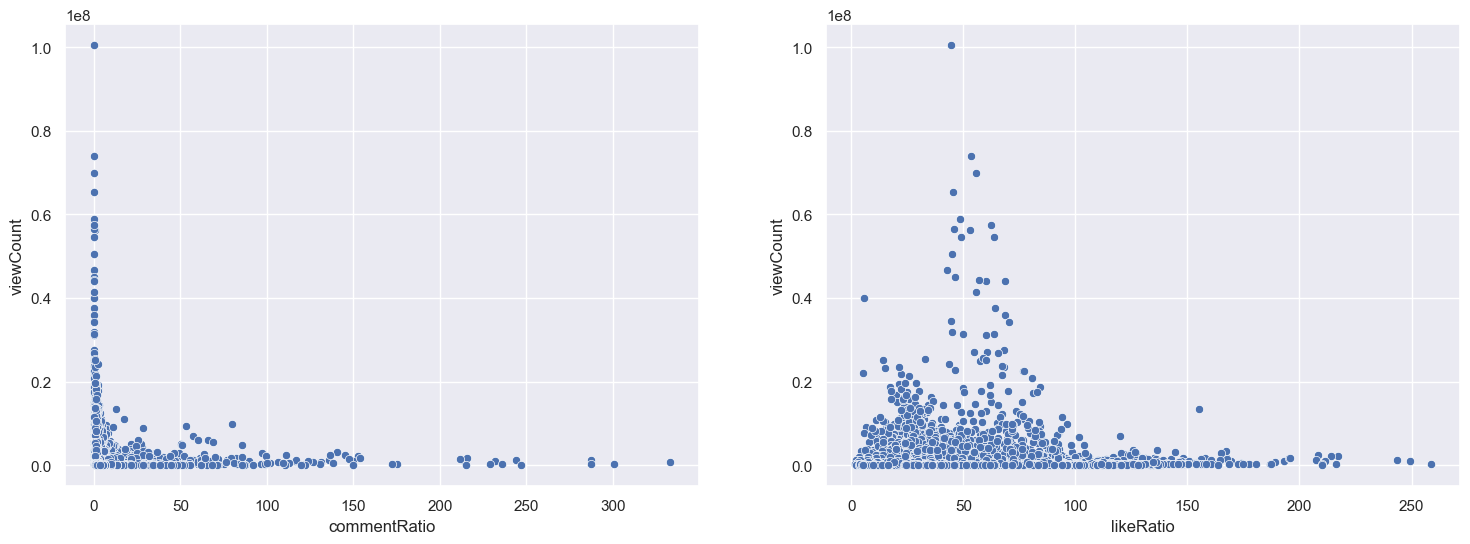

In [102]:
#comment ratio and like ratio instead of ablsolute number
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

<Axes: xlabel='durationSecs', ylabel='likeCount'>

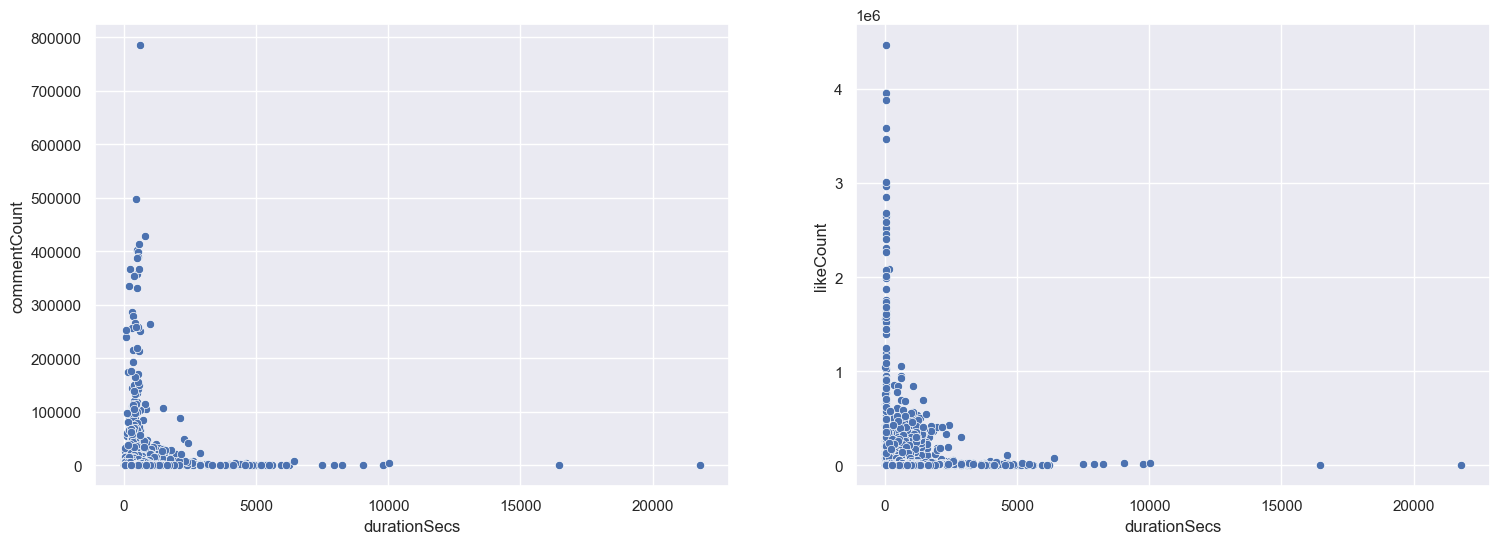

In [104]:
# duration against comment count and like count
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<Axes: xlabel='titleLength', ylabel='viewCount'>

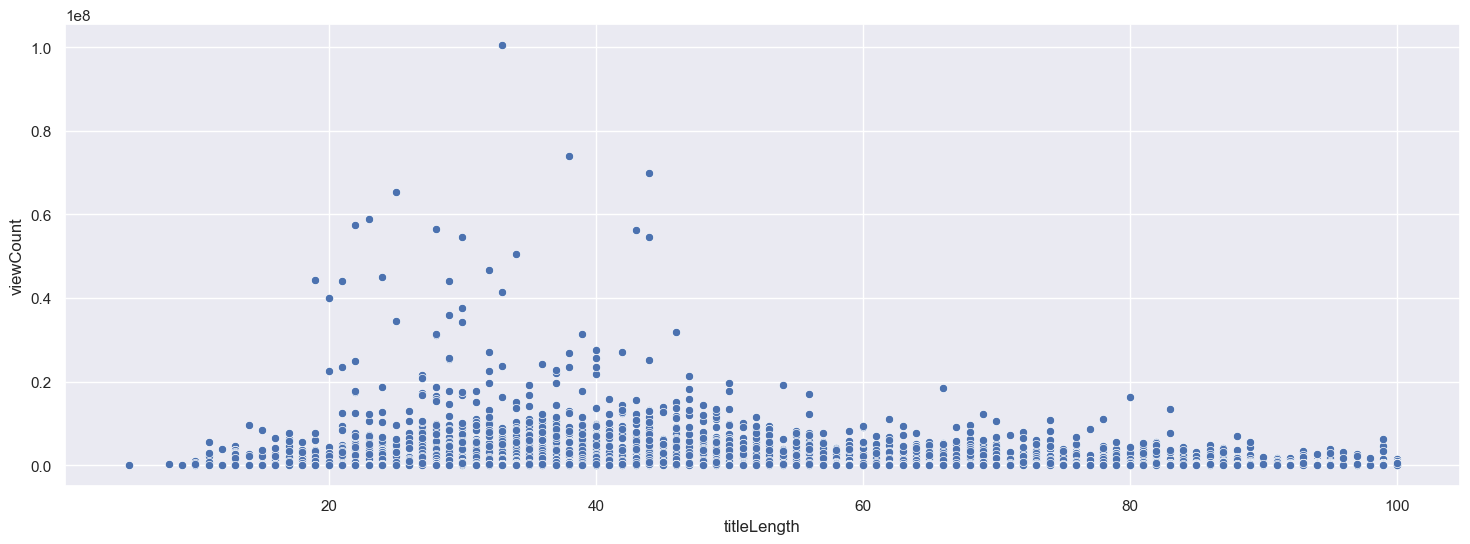

In [105]:
#Does title length matter for views?
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

<Axes: xlabel='tagsCount', ylabel='viewCount'>

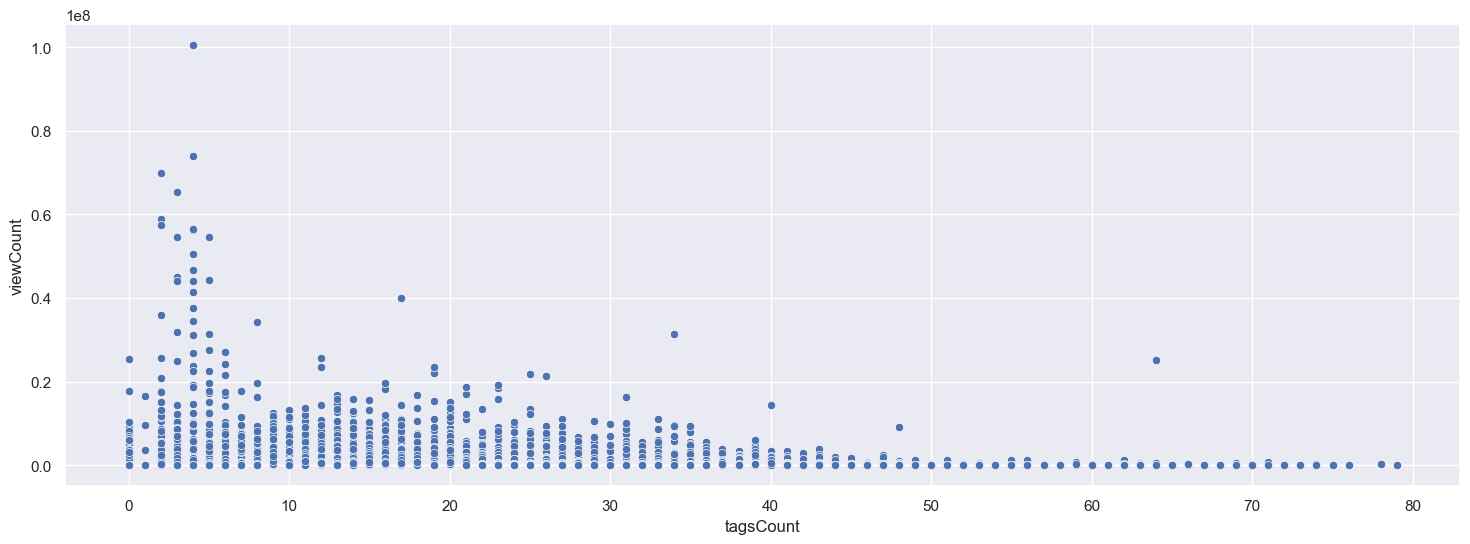

In [106]:
#Number of tags vs views
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

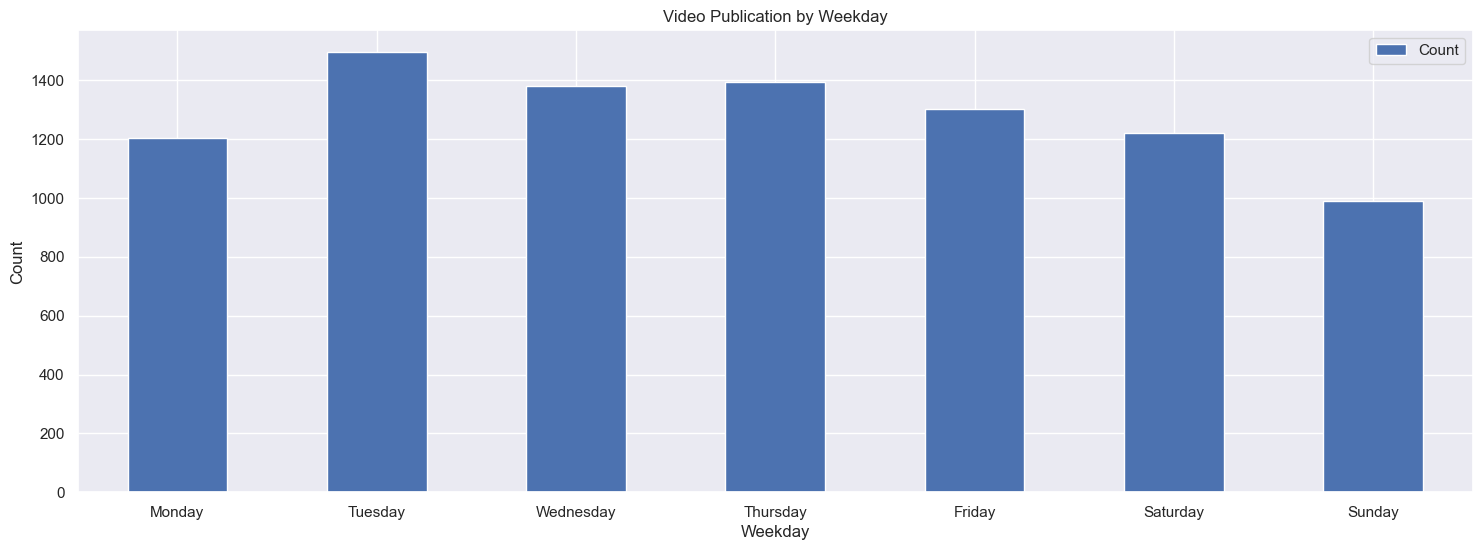

In [107]:
#Which day in the week are most videos uploaded?
day_df = video_df['pushblishDayName'].value_counts().reindex(weekdays, fill_value=0)

# Reset the index to have the weekdays as a column
day_df = day_df.reset_index()

# Rename the columns for clarity
day_df.columns = ['Weekday', 'Count']

# Create a bar plot
ax = day_df.plot.bar(x='Weekday', y='Count', rot=0)

# Customize the plot if needed (e.g., labels, title, etc.)
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Video Publication by Weekday')

# Show the plot
plt.show()